In [1]:
pip install prophet

  Using cached prophet-1.1.5-py3-none-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (3.5 kB)
  Using cached cmdstanpy-1.2.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached holidays-0.41-py3-none-any.whl.metadata (21 kB)
  Using cached stanio-0.3.0-py3-none-any.whl.metadata (963 bytes)
Using cached prophet-1.1.5-py3-none-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (14.7 MB)
Using cached cmdstanpy-1.2.0-py3-none-any.whl (93 kB)
Using cached holidays-0.41-py3-none-any.whl (913 kB)
Using cached stanio-0.3.0-py3-none-any.whl (6.2 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib widget
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


from sqlalchemy import create_engine

# Database connection details
db_config = {
    'user': 'admin',
    'password': 'quest',
    'host': 'questdb',
    'port': 8812, 
    'database': 'qdb'
}

# Create a database connection
engine = create_engine(f'postgresql://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}')

In [27]:
# Query to fetch data from your table
query = 'SELECT timestamp, count() FROM github_events sample by 1m align to calendar'

# Read data into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Data exploration (modify as needed)
print(df.head())
df.columns = [ 'ds', 'y']
df

            timestamp  count
0 2024-01-30 11:12:00    150
1 2024-01-30 11:13:00    180
2 2024-01-30 11:14:00    180
3 2024-01-30 11:15:00    150
4 2024-01-30 11:16:00     60


,ds,y
0,2024-01-30 11:12:00,150
1,2024-01-30 11:13:00,180
2,2024-01-30 11:14:00,180
3,2024-01-30 11:15:00,150
4,2024-01-30 11:16:00,60


In [24]:
# Creating and fitting the Prophet model
model = Prophet()
model.fit(df)

11:14:52 - cmdstanpy - INFO - Chain [1] start processing
11:14:52 - cmdstanpy - INFO - Chain [1] done processing


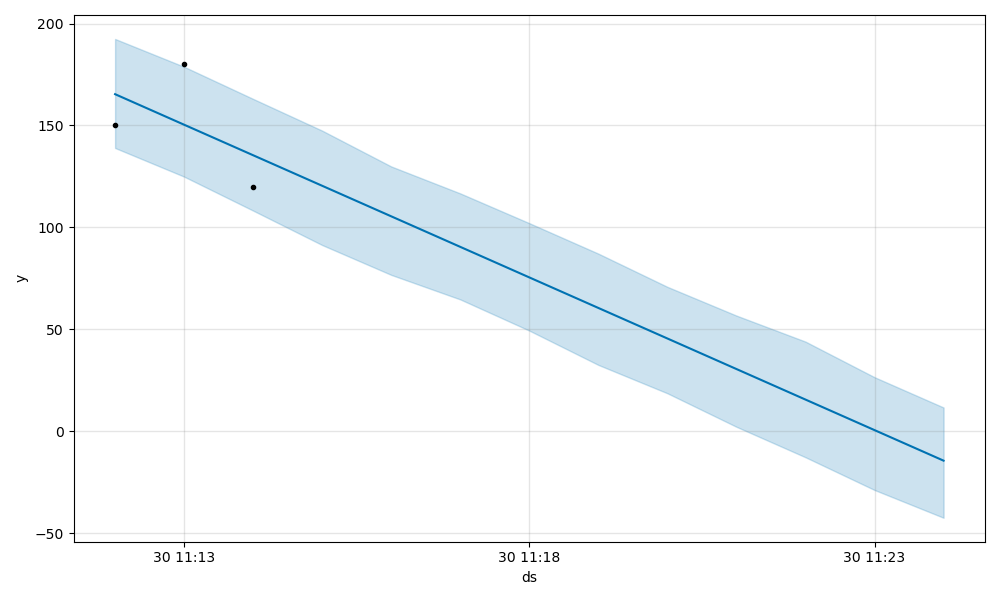

In [29]:
# Making future predictions
#future = model.make_future_dataframe(periods=30)  # Predicting 30 days into the future
future = model.make_future_dataframe(periods=10, freq='T')
forecast = model.predict(future)

# Plotting the forecast
model.plot(forecast)
plt.show()

In [30]:
%matplotlib widget

from sqlalchemy import create_engine
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Database connection details
db_config = {
    'user': 'admin',
    'password': 'quest',
    'host': 'questdb',
    'port': 8812, 
    'database': 'qdb'
}

# Create a database connection
engine = create_engine(f'postgresql://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}')

# SQL query to retrieve data from the "github_events" table with downsampling
query = 'SELECT timestamp, count() FROM github_events sample by 1m'

# Execute the query and fetch data into a DataFrame
df = pd.read_sql(query, engine)

# Data preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [31]:
# Create feature (X) and target (y) datasets
X = df.index.to_julian_date().values.reshape(-1, 1)
y = df['count'].values
df

,count
timestamp,
2024-01-30 11:12:08.463130,180
2024-01-30 11:13:08.463130,180
2024-01-30 11:14:08.463130,168
2024-01-30 11:15:08.463130,162
2024-01-30 11:16:08.463130,180
2024-01-30 11:17:08.463130,30


In [32]:
# Create and fit a Linear Regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

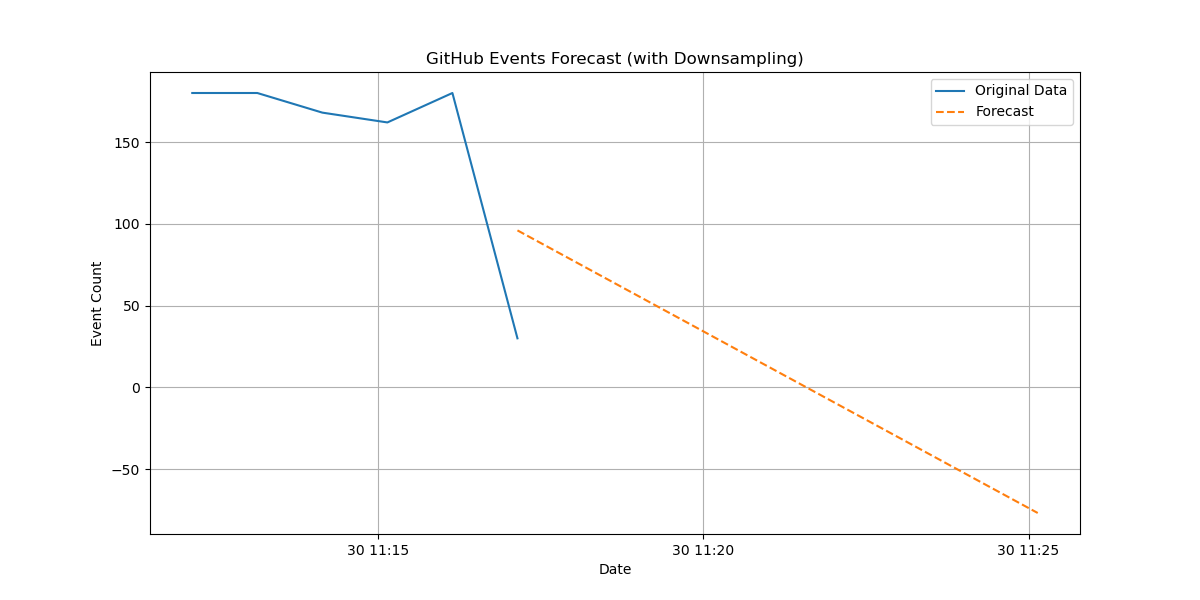

In [33]:
# Predict future values
future_minutes = 10 #30 * 24 * 60  # Number of minutes to forecast (30 days)
future_dates = pd.date_range(start=df.index[-1], periods=future_minutes, freq='T')
future_dates_jd = future_dates.to_julian_date().values.reshape(-1, 1)
future_forecast = model.predict(future_dates_jd)

# Exclude the last known date from the forecast
future_dates = future_dates[:-1]
future_forecast = future_forecast[:-1]

# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['count'], label='Original Data')
plt.plot(future_dates, future_forecast, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.title('GitHub Events Forecast (with Downsampling)')
plt.legend()
plt.grid()
plt.show()

In [19]:
pip install facets-overview

  Using cached facets_overview-1.1.1-py2.py3-none-any.whl.metadata (10 kB)
Using cached facets_overview-1.1.1-py2.py3-none-any.whl (22 kB)
Note: you may need to restart the kernel to use updated packages.


In [20]:
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

query = 'SELECT * FROM github_events '

# Execute the query and fetch data into a DataFrame
df = pd.read_sql(query, engine)


proto = GenericFeatureStatisticsGenerator().ProtoFromDataFrames([{'name': 'test', 'table': df}])

In [21]:
from IPython.core.display import display, HTML
import base64
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="/nbextensions/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))